In [1]:
from __future__ import print_function, division

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from astroML.utils.decorators import pickle_results
from astroML.datasets import fetch_sdss_specgals
from astroML.correlation import bootstrap_two_point_angular

In [2]:
#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=False)

#------------------------------------------------------------

In [3]:
ogdf = pd.DataFrame(fetch_sdss_specgals())
ogdf = ogdf.set_index("specObjID")
assert len(ogdf.index.unique()) == len(ogdf)

In [4]:
# Get data and do some quality cuts
# data = fetch_sdss_specgals()
import pandas as pd
df = pd.read_csv("SDSSspecgalsDR18.csv")
data = df.to_records(index=False)

In [5]:
m_max = 17.7

# redshift and magnitude cuts
data = data[data['z'] > 0.08]
data = data[data['z'] < 0.12]
data = data[data['petroMag_r'] < m_max]

In [6]:
subdf = pd.DataFrame(data)[["ra", "dec","z"]]
subdf['rarad'] = np.radians(subdf['ra'])
subdf['decrad'] = np.radians(subdf['dec'])

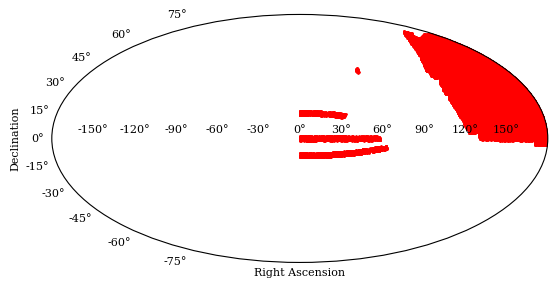

In [7]:
figure = plt.figure()
# figure.patch.set_facecolor('black') # setting plot background to dark color
ax = figure.add_subplot(111, projection='mollweide')
plt.scatter(subdf['rarad'], subdf['decrad'], s=1, color='red')
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
plt.show()

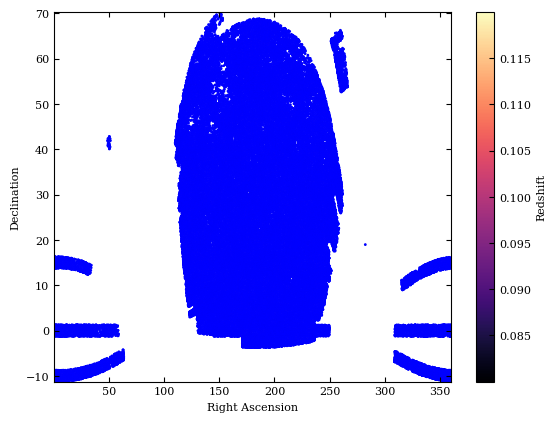

In [10]:
figure = plt.figure()
# figure.patch.set_facecolor('black') # setting plot background to dark color
plt.scatter(subdf['ra'], subdf['dec'], c=subdf["z"], cmap='magma', s=1)
plt.colorbar(label='Redshift')
plt.xlabel('Right Ascension')
plt.ylabel('Declination')
plt.show()

In [8]:
# RA/DEC cuts
RAmin, RAmax = 140, 220
DECmin, DECmax = 5, 40

data = data[data['ra'] < RAmax]
data = data[data['ra'] > RAmin]
data = data[data['dec'] < DECmax]
data = data[data['dec'] > DECmin]

In [9]:
ur = data['modelMag_u'] - data['modelMag_r']
flag_red = (ur > 2.22)
flag_blue = ~flag_red

In [10]:
data_red = data[flag_red]
data_blue = data[flag_blue]

In [11]:
print("data size:")
print("  red gals: ", len(data_red))
print("  blue gals:", len(data_blue))

data size:
  red gals:  34714
  blue gals: 15239


In [13]:
#------------------------------------------------------------
# Set up correlation function computation
#  This calculation takes a long time with the bootstrap resampling,
#  so we'll save the results.
@pickle_results("correlation_functions.pkl")
def compute_results(Nbins=16, Nbootstraps=10,  method='landy-szalay', rseed=0):
    np.random.seed(rseed)
    bins = 10 ** np.linspace(np.log10(1 / 60.), np.log10(6), 16)

    results = [bins]
    for D in [data_red, data_blue]:
        results += bootstrap_two_point_angular(D['ra'],
                                               D['dec'],
                                               bins=bins,
                                               method=method,
                                               Nbootstraps=Nbootstraps)

    return results

(bins, r_corr, r_corr_err, r_bootstraps,
 b_corr, b_corr_err, b_bootstraps) = compute_results()

bin_centers = 0.5 * (bins[1:] + bins[:-1])

@pickle_results: computing results and saving to 'correlation_functions.pkl'


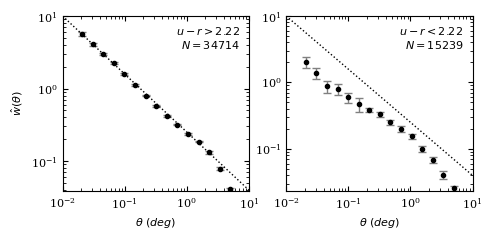

In [14]:
#------------------------------------------------------------
# Plot the results
corr = [r_corr, b_corr]
corr_err = [r_corr_err, b_corr_err]
bootstraps = [r_bootstraps, b_bootstraps]
labels = ['$u-r > 2.22$\n$N=%i$' % len(data_red),
          '$u-r < 2.22$\n$N=%i$' % len(data_blue)]

fig = plt.figure(figsize=(5, 2.5))
fig.subplots_adjust(bottom=0.2, top=0.9,
                    left=0.13, right=0.95)

for i in range(2):
    ax = fig.add_subplot(121 + i, xscale='log', yscale='log')

    ax.errorbar(bin_centers, corr[i], corr_err[i],
                fmt='.k', ecolor='gray', lw=1)

    t = np.array([0.01, 10])
    ax.plot(t, 10 * (t / 0.01) ** -0.8, ':k', linewidth=1)

    ax.text(0.95, 0.95, labels[i],
            ha='right', va='top', transform=ax.transAxes)
    ax.set_xlabel(r'$\theta\ (deg)$')
    if i == 0:
        ax.set_ylabel(r'$\hat{w}(\theta)$')


plt.show()
